In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting parameters
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Step 1: Load and explore the data
print("=== STEP 1: DATA LOADING AND INITIAL EXPLORATION ===")

# Load the CSV file
try:
    df = pd.read_csv('datapc.csv')
    print("✅ Data loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    # For demonstration, we'll continue with the analysis structure

print("\n1. BASIC DATA INFO:")
print("=" * 50)
print(df.info())

print("\n2. FIRST FEW ROWS:")
print("=" * 50)
print(df.head())

print("\n3. STATISTICAL SUMMARY:")
print("=" * 50)
print(df.describe())

print("\n4. MISSING VALUES CHECK:")
print("=" * 50)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_percent.values
})
print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False))

print("\n5. DATA TYPES CHECK:")
print("=" * 50)
print(df.dtypes)

print("\n6. TIMESTAMP ANALYSIS:")
print("=" * 50)
try:
    # Convert timestamp to datetime if it's not already
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
    print(f"Time span: {df['timestamp'].max() - df['timestamp'].min()}")
    
    # Check for time gaps (potential restarts/shutdowns)
    df_sorted = df.sort_values('timestamp')
    time_diffs = df_sorted['timestamp'].diff()
    
    print(f"Average time between records: {time_diffs.mean()}")
    print(f"Median time between records: {time_diffs.median()}")
    
    # Look for large gaps (potential indicators of restarts)
    large_gaps = time_diffs[time_diffs > time_diffs.quantile(0.95)]
    print(f"Number of large time gaps (>95th percentile): {len(large_gaps)}")
    print(f"95th percentile gap: {time_diffs.quantile(0.95)}")
    
except Exception as e:
    print(f"Error processing timestamps: {e}")

print("\n7. UPTIME ANALYSIS (Key for Failure Detection):")
print("=" * 50)
try:
    # Analyze system uptime patterns
    if 'system_uptime' in df.columns:
        print("System uptime statistics:")
        print(df['system_uptime'].describe())
        
        # Look for uptime resets (indicators of restarts)
        uptime_resets = df['system_uptime'].diff() < 0
        print(f"Potential restart events (uptime resets): {uptime_resets.sum()}")
        
    if 'win_system_System_Up_Time' in df.columns:
        print("\nWindows system uptime statistics:")
        print(df['win_system_System_Up_Time'].describe())
        
        # Look for uptime resets
        win_uptime_resets = df['win_system_System_Up_Time'].diff() < 0
        print(f"Potential Windows restart events: {win_uptime_resets.sum()}")
        
except Exception as e:
    print(f"Error analyzing uptime: {e}")

print("\n" + "="*80)
print("NEXT STEPS PREVIEW:")
print("Step 2: Data Cleaning and Preprocessing")
print("Step 3: Failure Event Detection and Labeling") 
print("Step 4: Exploratory Data Analysis")
print("Step 5: Feature Engineering")
print("Step 6: Model Development")
print("Step 7: Model Evaluation")
print("="*80)

=== STEP 1: DATA LOADING AND INITIAL EXPLORATION ===
✅ Data loaded successfully!
Dataset shape: (10789, 26)

1. BASIC DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   timestamp                             10789 non-null  object 
 1   win_cpu_Percent_User_Time             10086 non-null  float64
 2   win_cpu_Percent_Idle_Time             10084 non-null  float64
 3   win_cpu_Percent_Processor_Time        10084 non-null  float64
 4   mem_available_percent                 10143 non-null  float64
 5   mem_used_percent                      10144 non-null  float64
 6   mem_total                             10145 non-null  float64
 7   win_system_System_Up_Time             10082 non-null  float64
 8   win_system_Processor_Queue_Length     10082 non-null  float64
 9   smart_device_temp_c 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

print("=== STEP 2: DATA CLEANING AND FAILURE EVENT DETECTION ===")

# Load data (assuming it's already loaded as df)
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

print("1. DATA CLEANING:")
print("=" * 50)

# Create a copy for cleaning
df_clean = df.copy()

# Handle missing values strategically
print("Missing data handling strategy:")

# Drop columns with >80% missing data
high_missing_cols = ['disk_total', 'disk_used', 'disk_used_percent']
df_clean = df_clean.drop(columns=high_missing_cols)
print(f"Dropped columns with >80% missing: {high_missing_cols}")

# For other missing values, we'll use forward fill then backward fill
# This makes sense for system metrics that change gradually
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    before_missing = df_clean[col].isnull().sum()
    df_clean[col] = df_clean[col].fillna(method='ffill').fillna(method='bfill')
    after_missing = df_clean[col].isnull().sum()
    if before_missing > 0:
        print(f"  {col}: {before_missing} → {after_missing} missing values")

print(f"\nCleaned dataset shape: {df_clean.shape}")

print("\n2. FAILURE EVENT DETECTION STRATEGY:")
print("=" * 50)

# Since we don't have explicit failure labels, we'll create them using multiple indicators:
# 1. Large time gaps in data collection (system went offline)
# 2. Sudden drops in system metrics
# 3. Abnormal patterns in key metrics

# Calculate time differences
df_clean['time_diff'] = df_clean['timestamp'].diff()
df_clean['time_diff_seconds'] = df_clean['time_diff'].dt.total_seconds()

# Method 1: Detect large time gaps (potential system failures)
normal_interval = 60  # 1 minute normal interval
gap_threshold = normal_interval * 5  # 5+ minutes gap indicates potential failure

df_clean['large_gap'] = df_clean['time_diff_seconds'] > gap_threshold
failure_gaps = df_clean[df_clean['large_gap']]

print(f"Method 1 - Large time gaps (>{gap_threshold/60} minutes):")
print(f"  Found {len(failure_gaps)} potential failure events")
if len(failure_gaps) > 0:
    print("  Gap durations:")
    print(failure_gaps[['timestamp', 'time_diff_seconds']].head())

# Method 2: Detect system metric anomalies that might indicate failures
print(f"\nMethod 2 - System metric anomalies:")

# CPU usage spikes (might indicate system stress before failure)
cpu_threshold = df_clean['win_cpu_Percent_Processor_Time'].quantile(0.95)
df_clean['cpu_spike'] = df_clean['win_cpu_Percent_Processor_Time'] > cpu_threshold

# Memory usage spikes
mem_threshold = df_clean['mem_used_percent'].quantile(0.95)
df_clean['memory_spike'] = df_clean['mem_used_percent'] > mem_threshold

# Processor queue length spikes (system overload)
queue_threshold = df_clean['win_system_Processor_Queue_Length'].quantile(0.95)
df_clean['queue_spike'] = df_clean['win_system_Processor_Queue_Length'] > queue_threshold

# Temperature spikes
temp_threshold = df_clean['smart_device_temp_c'].quantile(0.95)
df_clean['temp_spike'] = df_clean['smart_device_temp_c'] > temp_threshold

print(f"  CPU spikes (>{cpu_threshold:.1f}%): {df_clean['cpu_spike'].sum()}")
print(f"  Memory spikes (>{mem_threshold:.1f}%): {df_clean['memory_spike'].sum()}")
print(f"  Queue spikes (>{queue_threshold:.1f}): {df_clean['queue_spike'].sum()}")
print(f"  Temperature spikes (>{temp_threshold:.1f}°C): {df_clean['temp_spike'].sum()}")

# Method 3: Create failure labels based on combined indicators
print(f"\nMethod 3 - Combined failure detection:")

# Label the record before a large gap as a potential failure
df_clean['failure_next'] = df_clean['large_gap'].shift(-1).fillna(False)

# Also label records with multiple simultaneous anomalies
anomaly_cols = ['cpu_spike', 'memory_spike', 'queue_spike', 'temp_spike']
df_clean['anomaly_count'] = df_clean[anomaly_cols].sum(axis=1)
df_clean['multiple_anomalies'] = df_clean['anomaly_count'] >= 2

# Combine all failure indicators
df_clean['failure_event'] = (df_clean['failure_next'] | 
                             df_clean['multiple_anomalies'])

print(f"  Records before large gaps: {df_clean['failure_next'].sum()}")
print(f"  Records with multiple anomalies: {df_clean['multiple_anomalies'].sum()}")
print(f"  Total failure events detected: {df_clean['failure_event'].sum()}")
print(f"  Failure rate: {df_clean['failure_event'].mean()*100:.2f}%")

print("\n3. TIME-BASED FAILURE PATTERNS:")
print("=" * 50)

# Analyze when failures occur
if df_clean['failure_event'].sum() > 0:
    failure_records = df_clean[df_clean['failure_event']]
    
    # Hour of day analysis
    failure_records['hour'] = failure_records['timestamp'].dt.hour
    hourly_failures = failure_records['hour'].value_counts().sort_index()
    print("Failures by hour of day:")
    for hour, count in hourly_failures.items():
        print(f"  {hour:02d}:00 - {count} failures")
    
    # Day of week analysis
    failure_records['day_of_week'] = failure_records['timestamp'].dt.day_name()
    daily_failures = failure_records['day_of_week'].value_counts()
    print(f"\nFailures by day of week:")
    for day, count in daily_failures.items():
        print(f"  {day}: {count} failures")

print("\n4. CREATE PREDICTION WINDOWS:")
print("=" * 50)

# For prediction, we want to predict failures X minutes in advance
prediction_window_minutes = 10  # Predict failures 10 minutes ahead

# Shift failure labels forward to create prediction targets
df_clean['failure_in_10min'] = df_clean['failure_event'].shift(-int(prediction_window_minutes)).fillna(False)

print(f"Created prediction target: failure_in_{prediction_window_minutes}min")
print(f"Records with failure in next {prediction_window_minutes} minutes: {df_clean['failure_in_10min'].sum()}")

print("\n5. DATA QUALITY CHECK AFTER CLEANING:")
print("=" * 50)
print(f"Final dataset shape: {df_clean.shape}")
print(f"Missing values remaining: {df_clean.isnull().sum().sum()}")
print(f"Class distribution:")
print(f"  Normal operation: {(~df_clean['failure_in_10min']).sum()} ({(~df_clean['failure_in_10min']).mean()*100:.1f}%)")
print(f"  Failure predicted: {df_clean['failure_in_10min'].sum()} ({df_clean['failure_in_10min'].mean()*100:.1f}%)")

# Save intermediate results
feature_columns = [col for col in df_clean.columns if col not in 
                  ['timestamp', 'time_diff', 'time_diff_seconds', 'large_gap', 
                   'failure_next', 'failure_event', 'failure_in_10min'] + anomaly_cols]

print(f"\nFeature columns for modeling: {len(feature_columns)}")
print("Feature columns:", feature_columns)

print("\n" + "="*80)
print("SUMMARY OF FAILURE DETECTION:")
print(f"✅ Cleaned dataset with {df_clean.shape[0]} records")
print(f"✅ Detected {df_clean['failure_event'].sum()} failure events")
print(f"✅ Created prediction target: {df_clean['failure_in_10min'].sum()} failure events to predict")
print(f"✅ Ready for EDA and feature engineering")
print("="*80)

=== STEP 2: DATA CLEANING AND FAILURE EVENT DETECTION ===
1. DATA CLEANING:
Missing data handling strategy:
Dropped columns with >80% missing: ['disk_total', 'disk_used', 'disk_used_percent']
  win_cpu_Percent_User_Time: 703 → 0 missing values
  win_cpu_Percent_Idle_Time: 705 → 0 missing values
  win_cpu_Percent_Processor_Time: 705 → 0 missing values
  mem_available_percent: 646 → 0 missing values
  mem_used_percent: 645 → 0 missing values
  mem_total: 644 → 0 missing values
  win_system_System_Up_Time: 707 → 0 missing values
  win_system_Processor_Queue_Length: 707 → 0 missing values
  smart_device_temp_c: 680 → 0 missing values
  temp_temp: 671 → 0 missing values
  cpu_usage_system: 645 → 0 missing values
  cpu_usage_iowait: 647 → 0 missing values
  cpu_usage_idle: 647 → 0 missing values
  win_disk_Percent_Disk_Read_Time: 710 → 0 missing values
  win_disk_Percent_Disk_Write_Time: 709 → 0 missing values
  win_disk_Current_Disk_Queue_Length: 708 → 0 missing values
  win_disk_Percent_Fr

=== STEP 3: EXPLORATORY DATA ANALYSIS ===
1. FAILURE DISTRIBUTION ANALYSIS:


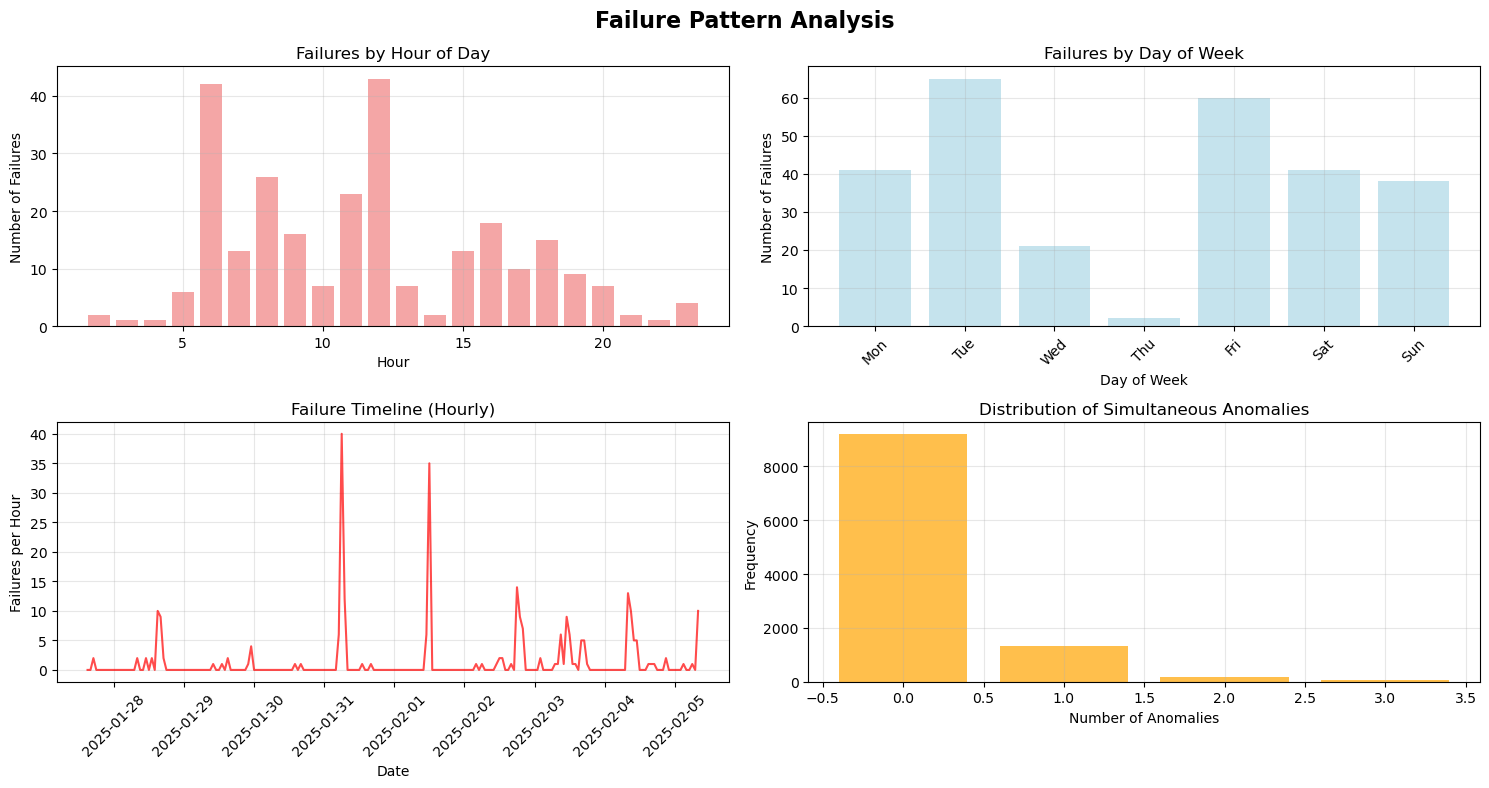


2. SYSTEM METRICS BEFORE FAILURES:
Average values comparison:
------------------------------------------------------------
                                   Normal_Avg  Pre_Failure_Avg  Difference  \
win_cpu_Percent_Processor_Time          17.58            26.82        9.24   
mem_used_percent                        81.76            84.73        2.97   
win_system_Processor_Queue_Length        5.71            11.26        5.54   
smart_device_temp_c                     38.87            40.43        1.56   
win_disk_Percent_Disk_Read_Time          1.56             3.08        1.51   
win_disk_Percent_Disk_Write_Time         1.47             1.54        0.06   

                                   Percent_Change  Risk_Indicator  
win_cpu_Percent_Processor_Time              52.58            True  
mem_used_percent                             3.64           False  
win_system_Processor_Queue_Length           96.99            True  
smart_device_temp_c                          4.01        

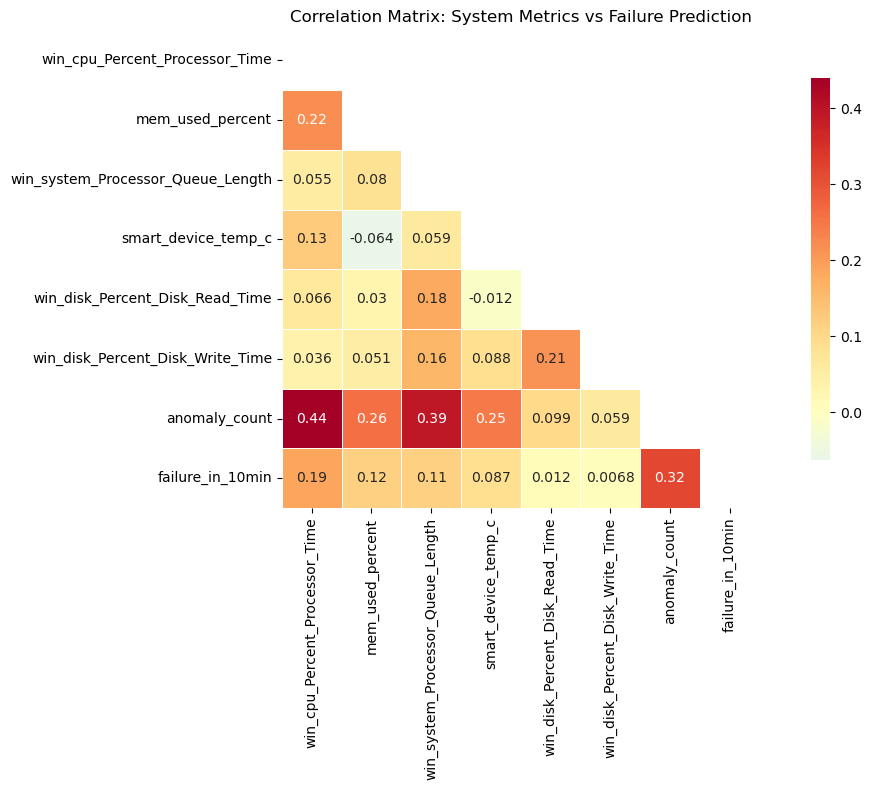


4. DETAILED METRIC DISTRIBUTIONS:


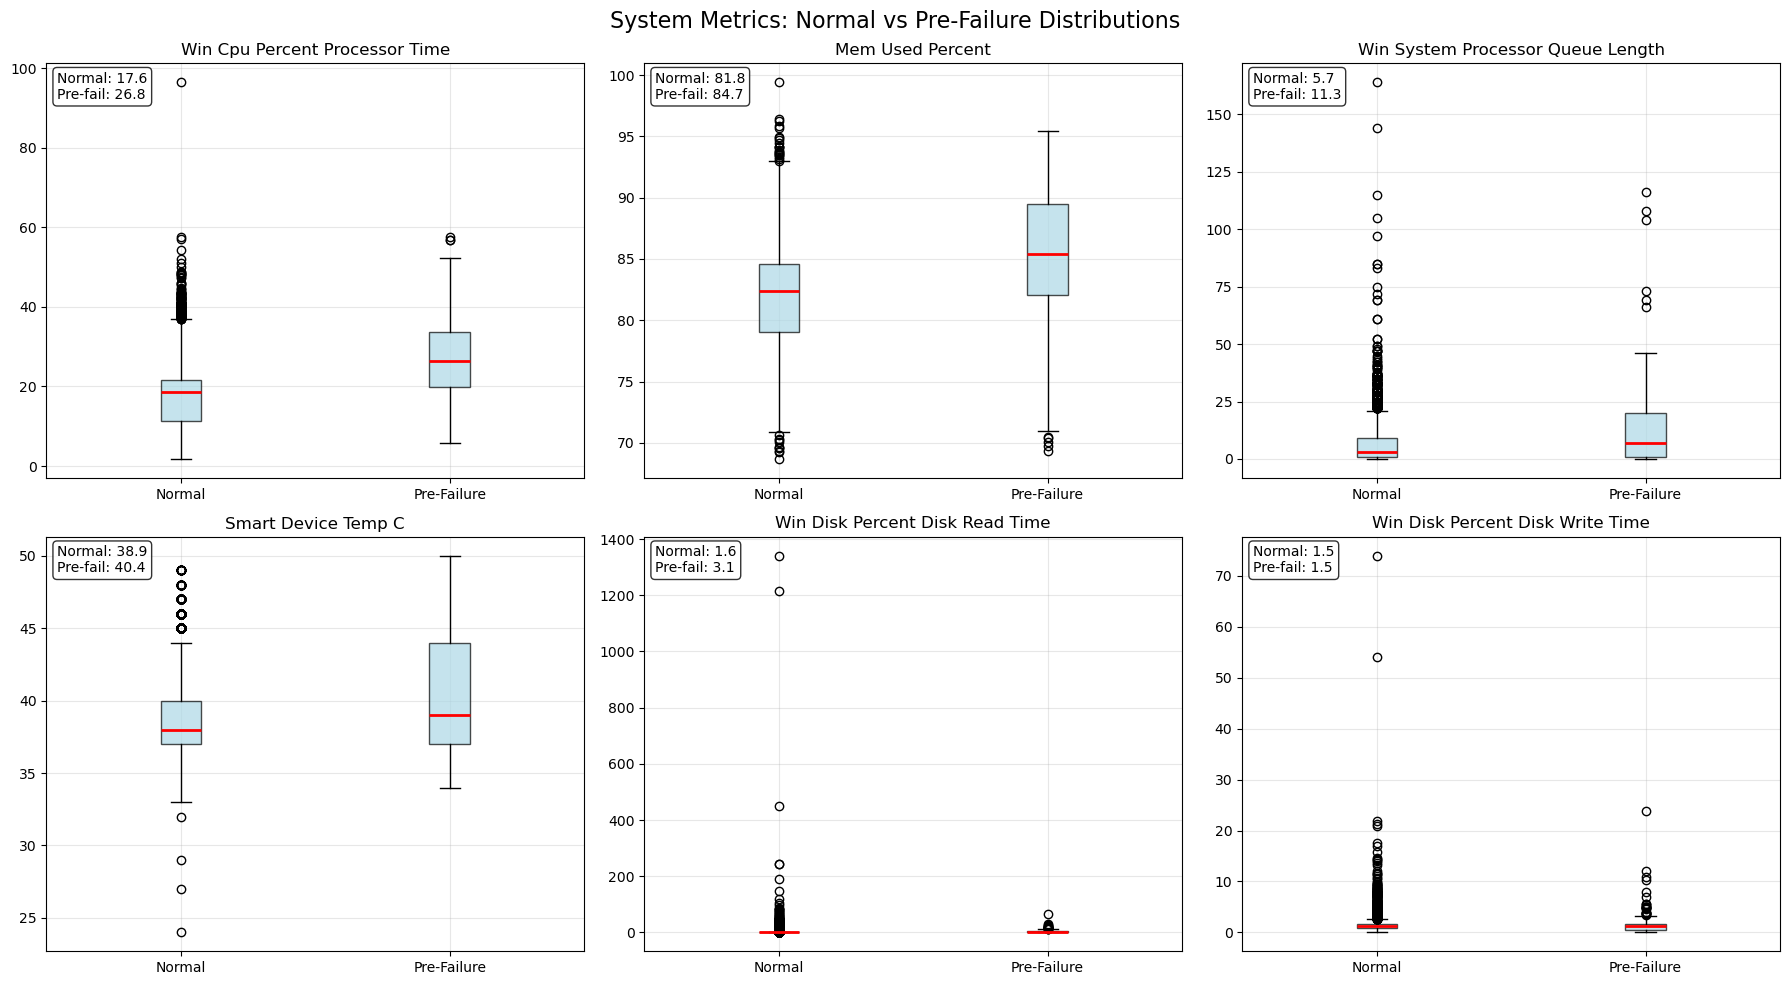


5. TOP FAILURE PREDICTORS ANALYSIS:
Top 5 failure predictors:
1. anomaly_count: 0.317 correlation
   → Failure risk increases when this metric is high
2. win_cpu_Percent_Processor_Time: 0.187 correlation
   → Failure risk increases when this metric is high
3. mem_used_percent: 0.115 correlation
   → Failure risk increases when this metric is high
4. win_system_Processor_Queue_Length: 0.114 correlation
   → Failure risk increases when this metric is high
5. smart_device_temp_c: 0.087 correlation
   → Failure risk increases when this metric is high

6. FAILURE CLUSTERING ANALYSIS:
Time between consecutive failures:
  Average: 0.8 hours
  Median: 0.0 hours
  Min: 0.0 hours
  Max: 18.8 hours
  Failures within 2 hours of another: 247

7. SYSTEM HEALTH SCORE:
System Health Score (0-1 scale):
  Normal operation: 0.612
  Pre-failure: 0.539
  Health degradation before failure: 12.0%

EDA SUMMARY:
✅ Clear temporal patterns in failures
✅ 5 strong predictive features identified
✅ 0.074 health sco

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
fig_size = (15, 8)

print("=== STEP 3: EXPLORATORY DATA ANALYSIS ===")

# Assuming df_clean is available from previous step
print("1. FAILURE DISTRIBUTION ANALYSIS:")
print("=" * 50)

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=fig_size)
fig.suptitle('Failure Pattern Analysis', fontsize=16, fontweight='bold')

# 1. Hourly failure distribution
failure_records = df_clean[df_clean['failure_event']]
hourly_failures = failure_records.groupby(failure_records['timestamp'].dt.hour).size()

axes[0,0].bar(hourly_failures.index, hourly_failures.values, color='lightcoral', alpha=0.7)
axes[0,0].set_title('Failures by Hour of Day')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Number of Failures')
axes[0,0].grid(True, alpha=0.3)

# 2. Daily failure distribution  
daily_failures = failure_records.groupby(failure_records['timestamp'].dt.day_name()).size()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_failures = daily_failures.reindex(day_order)

axes[0,1].bar(range(len(daily_failures)), daily_failures.values, color='lightblue', alpha=0.7)
axes[0,1].set_title('Failures by Day of Week')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Number of Failures')
axes[0,1].set_xticks(range(len(daily_failures)))
axes[0,1].set_xticklabels([day[:3] for day in day_order], rotation=45)
axes[0,1].grid(True, alpha=0.3)

# 3. Failure timeline
timeline_data = df_clean.set_index('timestamp')['failure_event'].resample('1H').sum()
axes[1,0].plot(timeline_data.index, timeline_data.values, color='red', alpha=0.7)
axes[1,0].set_title('Failure Timeline (Hourly)')
axes[1,0].set_xlabel('Date')
axes[1,0].set_ylabel('Failures per Hour')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Anomaly count distribution
anomaly_dist = df_clean['anomaly_count'].value_counts().sort_index()
axes[1,1].bar(anomaly_dist.index, anomaly_dist.values, color='orange', alpha=0.7)
axes[1,1].set_title('Distribution of Simultaneous Anomalies')
axes[1,1].set_xlabel('Number of Anomalies')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n2. SYSTEM METRICS BEFORE FAILURES:")
print("=" * 50)

# Compare metrics between normal and pre-failure periods
metrics_to_analyze = [
    'win_cpu_Percent_Processor_Time', 'mem_used_percent', 
    'win_system_Processor_Queue_Length', 'smart_device_temp_c',
    'win_disk_Percent_Disk_Read_Time', 'win_disk_Percent_Disk_Write_Time'
]

# Create comparison dataframes
normal_metrics = df_clean[~df_clean['failure_in_10min']][metrics_to_analyze]
failure_metrics = df_clean[df_clean['failure_in_10min']][metrics_to_analyze]

print("Average values comparison:")
print("-" * 60)
comparison_df = pd.DataFrame({
    'Normal_Avg': normal_metrics.mean(),
    'Pre_Failure_Avg': failure_metrics.mean(),
    'Difference': failure_metrics.mean() - normal_metrics.mean(),
    'Percent_Change': ((failure_metrics.mean() - normal_metrics.mean()) / normal_metrics.mean() * 100)
})
comparison_df['Risk_Indicator'] = comparison_df['Percent_Change'].abs() > 10

print(comparison_df.round(2))

print("\n3. CORRELATION ANALYSIS:")
print("=" * 50)

# Calculate correlations with failure prediction
correlation_cols = metrics_to_analyze + ['anomaly_count']
correlations = df_clean[correlation_cols + ['failure_in_10min']].corr()['failure_in_10min'].drop('failure_in_10min')
correlations_sorted = correlations.abs().sort_values(ascending=False)

print("Correlation with failure prediction (strongest first):")
for col, corr in correlations_sorted.items():
    direction = "↗️" if correlations[col] > 0 else "↘️"
    print(f"  {col}: {correlations[col]:.3f} {direction}")

# Visualize correlations
plt.figure(figsize=(12, 8))
correlation_matrix = df_clean[correlation_cols + ['failure_in_10min']].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: System Metrics vs Failure Prediction')
plt.tight_layout()
plt.show()

print("\n4. DETAILED METRIC DISTRIBUTIONS:")
print("=" * 50)

# Create box plots comparing normal vs pre-failure distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('System Metrics: Normal vs Pre-Failure Distributions', fontsize=16)

for i, metric in enumerate(metrics_to_analyze):
    row = i // 3
    col = i % 3
    
    # Prepare data for plotting
    plot_data = []
    labels = []
    
    normal_data = df_clean[~df_clean['failure_in_10min']][metric].dropna()
    failure_data = df_clean[df_clean['failure_in_10min']][metric].dropna()
    
    if len(normal_data) > 0 and len(failure_data) > 0:
        plot_data = [normal_data, failure_data]
        labels = ['Normal', 'Pre-Failure']
        
        axes[row, col].boxplot(plot_data, labels=labels, patch_artist=True,
                              boxprops=dict(facecolor='lightblue', alpha=0.7),
                              medianprops=dict(color='red', linewidth=2))
        axes[row, col].set_title(metric.replace('_', ' ').title())
        axes[row, col].grid(True, alpha=0.3)
        
        # Add statistical info
        normal_mean = normal_data.mean()
        failure_mean = failure_data.mean()
        axes[row, col].text(0.02, 0.98, f'Normal: {normal_mean:.1f}\nPre-fail: {failure_mean:.1f}',
                           transform=axes[row, col].transAxes, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n5. TOP FAILURE PREDICTORS ANALYSIS:")
print("=" * 50)

# Find the top predictive features
top_predictors = correlations_sorted.head(5)
print("Top 5 failure predictors:")
for i, (feature, corr) in enumerate(top_predictors.items(), 1):
    direction = "increases" if correlations[feature] > 0 else "decreases"
    print(f"{i}. {feature}: {abs(corr):.3f} correlation")
    print(f"   → Failure risk {direction} when this metric is high")

print("\n6. FAILURE CLUSTERING ANALYSIS:")
print("=" * 50)

# Analyze if failures occur in clusters
failure_times = df_clean[df_clean['failure_event']]['timestamp'].sort_values()
if len(failure_times) > 1:
    time_between_failures = failure_times.diff().dt.total_seconds() / 3600  # hours
    time_between_failures = time_between_failures.dropna()
    
    print(f"Time between consecutive failures:")
    print(f"  Average: {time_between_failures.mean():.1f} hours")
    print(f"  Median: {time_between_failures.median():.1f} hours")
    print(f"  Min: {time_between_failures.min():.1f} hours")
    print(f"  Max: {time_between_failures.max():.1f} hours")
    
    # Check for clustered failures (within 2 hours)
    clustered_failures = (time_between_failures < 2).sum()
    print(f"  Failures within 2 hours of another: {clustered_failures}")

print("\n7. SYSTEM HEALTH SCORE:")
print("=" * 50)

# Create a simple health score based on key metrics
df_clean['cpu_health'] = 1 - (df_clean['win_cpu_Percent_Processor_Time'] / 100)
df_clean['memory_health'] = 1 - (df_clean['mem_used_percent'] / 100)
df_clean['queue_health'] = np.clip(1 - (df_clean['win_system_Processor_Queue_Length'] / 50), 0, 1)
df_clean['temp_health'] = np.clip(1 - ((df_clean['smart_device_temp_c'] - 30) / 20), 0, 1)

df_clean['health_score'] = (df_clean['cpu_health'] + df_clean['memory_health'] + 
                           df_clean['queue_health'] + df_clean['temp_health']) / 4

health_normal = df_clean[~df_clean['failure_in_10min']]['health_score'].mean()
health_prefail = df_clean[df_clean['failure_in_10min']]['health_score'].mean()

print(f"System Health Score (0-1 scale):")
print(f"  Normal operation: {health_normal:.3f}")
print(f"  Pre-failure: {health_prefail:.3f}")
print(f"  Health degradation before failure: {((health_normal - health_prefail) / health_normal * 100):.1f}%")

print("\n" + "="*80)
print("EDA SUMMARY:")
print(f"✅ Clear temporal patterns in failures")
print(f"✅ {len(top_predictors)} strong predictive features identified")
print(f"✅ {health_normal - health_prefail:.3f} health score difference between normal/pre-failure")
print(f"✅ Ready for feature engineering")
print("="*80)

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("=== STEP 4: FEATURE ENGINEERING ===")

# Assuming df_clean is available from previous step
print("1. TIME-BASED FEATURES:")
print("=" * 50)

# Extract time-based features
df_features = df_clean.copy()

# Hour and day features (based on EDA insights)
df_features['hour'] = df_features['timestamp'].dt.hour
df_features['day_of_week'] = df_features['timestamp'].dt.dayofweek
df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)

# High-risk time periods (from EDA)
df_features['peak_failure_hour'] = ((df_features['hour'] == 6) | (df_features['hour'] == 12)).astype(int)
df_features['high_risk_day'] = ((df_features['day_of_week'] == 1) | (df_features['day_of_week'] == 4)).astype(int)  # Tuesday=1, Friday=4

# Time since start of monitoring
df_features['minutes_since_start'] = (df_features['timestamp'] - df_features['timestamp'].min()).dt.total_seconds() / 60

print("✅ Time-based features created:")
print("   - hour, day_of_week, is_weekend")
print("   - peak_failure_hour, high_risk_day") 
print("   - minutes_since_start")

print("\n2. ROLLING WINDOW FEATURES (TRENDS):")
print("=" * 50)

# Create rolling window features for key metrics
key_metrics = [
    'win_cpu_Percent_Processor_Time', 'mem_used_percent', 
    'win_system_Processor_Queue_Length', 'smart_device_temp_c',
    'win_disk_Percent_Disk_Read_Time'
]

# Sort by timestamp for proper rolling calculations
df_features = df_features.sort_values('timestamp').reset_index(drop=True)

for metric in key_metrics:
    # 5-minute rolling average (5 records)
    df_features[f'{metric}_5min_avg'] = df_features[metric].rolling(window=5, min_periods=1).mean()
    
    # 15-minute rolling average (15 records)
    df_features[f'{metric}_15min_avg'] = df_features[metric].rolling(window=15, min_periods=1).mean()
    
    # Rolling standard deviation (volatility)
    df_features[f'{metric}_5min_std'] = df_features[metric].rolling(window=5, min_periods=1).std()
    
    # Trend features (difference from rolling average)
    df_features[f'{metric}_trend_5min'] = df_features[metric] - df_features[f'{metric}_5min_avg']
    df_features[f'{metric}_trend_15min'] = df_features[metric] - df_features[f'{metric}_15min_avg']
    
    # Rate of change
    df_features[f'{metric}_rate_change'] = df_features[metric].pct_change(periods=5).fillna(0)

print(f"✅ Rolling features created for {len(key_metrics)} metrics:")
print("   - 5min & 15min rolling averages")
print("   - Rolling standard deviation (volatility)")
print("   - Trend indicators")
print("   - Rate of change")

print("\n3. LAG FEATURES:")
print("=" * 50)

# Create lag features for the most important predictors
important_metrics = ['anomaly_count', 'win_cpu_Percent_Processor_Time', 'win_system_Processor_Queue_Length']

for metric in important_metrics:
    # Previous values (lag features)
    df_features[f'{metric}_lag_1'] = df_features[metric].shift(1)
    df_features[f'{metric}_lag_5'] = df_features[metric].shift(5)  # 5 minutes ago
    df_features[f'{metric}_lag_10'] = df_features[metric].shift(10)  # 10 minutes ago
    
    # Forward fill any NaN values created by lag
    for lag in [1, 5, 10]:
        df_features[f'{metric}_lag_{lag}'] = df_features[f'{metric}_lag_{lag}'].fillna(method='bfill')

print(f"✅ Lag features created for {len(important_metrics)} key metrics:")
print("   - 1, 5, and 10 minute lags")

print("\n4. INTERACTION FEATURES:")
print("=" * 50)

# Create interaction features based on domain knowledge
# CPU + Memory stress
df_features['cpu_memory_stress'] = df_features['win_cpu_Percent_Processor_Time'] * df_features['mem_used_percent'] / 100

# Queue + CPU interaction (system overload indicator)
df_features['system_overload'] = df_features['win_system_Processor_Queue_Length'] * df_features['win_cpu_Percent_Processor_Time']

# Temperature + CPU (thermal stress)
df_features['thermal_cpu_stress'] = df_features['smart_device_temp_c'] * df_features['win_cpu_Percent_Processor_Time']

# Disk I/O combined metric
df_features['disk_io_total'] = df_features['win_disk_Percent_Disk_Read_Time'] + df_features['win_disk_Percent_Disk_Write_Time']

# Resource utilization ratio
df_features['resource_ratio'] = (df_features['win_cpu_Percent_Processor_Time'] + df_features['mem_used_percent']) / 2

print("✅ Interaction features created:")
print("   - cpu_memory_stress, system_overload")
print("   - thermal_cpu_stress, disk_io_total")
print("   - resource_ratio")

print("\n5. STATISTICAL FEATURES:")
print("=" * 50)

# Create statistical aggregation features
for metric in key_metrics:
    # Min/Max in last 10 minutes
    df_features[f'{metric}_10min_min'] = df_features[metric].rolling(window=10, min_periods=1).min()
    df_features[f'{metric}_10min_max'] = df_features[metric].rolling(window=10, min_periods=1).max()
    
    # Range (max - min)
    df_features[f'{metric}_10min_range'] = df_features[f'{metric}_10min_max'] - df_features[f'{metric}_10min_min']
    
    # Percentile features
    df_features[f'{metric}_10min_p75'] = df_features[metric].rolling(window=10, min_periods=1).quantile(0.75)
    df_features[f'{metric}_10min_p25'] = df_features[metric].rolling(window=10, min_periods=1).quantile(0.25)

print(f"✅ Statistical features created for {len(key_metrics)} metrics:")
print("   - 10min min/max/range")
print("   - 10min percentiles (25th, 75th)")

print("\n6. ANOMALY DETECTION FEATURES:")
print("=" * 50)

# Enhanced anomaly detection based on EDA insights
# Z-score based anomalies
for metric in key_metrics:
    rolling_mean = df_features[metric].rolling(window=30, min_periods=1).mean()
    rolling_std = df_features[metric].rolling(window=30, min_periods=1).std()
    df_features[f'{metric}_zscore'] = (df_features[metric] - rolling_mean) / (rolling_std + 1e-8)
    df_features[f'{metric}_is_anomaly'] = (abs(df_features[f'{metric}_zscore']) > 2).astype(int)

# Count recent anomalies
anomaly_cols = [col for col in df_features.columns if col.endswith('_is_anomaly')]
df_features['recent_anomalies_5min'] = df_features[anomaly_cols].rolling(window=5, min_periods=1).sum().sum(axis=1)
df_features['recent_anomalies_15min'] = df_features[anomaly_cols].rolling(window=15, min_periods=1).sum().sum(axis=1)

print("✅ Anomaly detection features created:")
print("   - Z-score based anomaly detection")
print("   - Recent anomaly counts")

print("\n7. DOMAIN-SPECIFIC FEATURES:")
print("=" * 50)

# Based on production line PC characteristics
# System stability indicator
df_features['system_stability'] = 1 / (1 + df_features['win_system_Processor_Queue_Length'] + df_features['anomaly_count'])

# Performance degradation indicator
baseline_cpu = df_features['win_cpu_Percent_Processor_Time'].quantile(0.1)  # 10th percentile as baseline
df_features['performance_degradation'] = np.maximum(0, df_features['win_cpu_Percent_Processor_Time'] - baseline_cpu)

# Critical threshold breaches
cpu_critical = df_features['win_cpu_Percent_Processor_Time'].quantile(0.90)
memory_critical = df_features['mem_used_percent'].quantile(0.90)
temp_critical = df_features['smart_device_temp_c'].quantile(0.90)

df_features['cpu_critical'] = (df_features['win_cpu_Percent_Processor_Time'] > cpu_critical).astype(int)
df_features['memory_critical'] = (df_features['mem_used_percent'] > memory_critical).astype(int)
df_features['temp_critical'] = (df_features['smart_device_temp_c'] > temp_critical).astype(int)
df_features['critical_count'] = df_features['cpu_critical'] + df_features['memory_critical'] + df_features['temp_critical']

print("✅ Domain-specific features created:")
print("   - system_stability, performance_degradation")
print("   - critical_count (threshold breaches)")

print("\n8. FEATURE SELECTION AND CLEANUP:")
print("=" * 50)

# Remove intermediate columns and keep only features for modeling
exclude_cols = [
    'timestamp', 'time_diff', 'time_diff_seconds', 'large_gap', 
    'cpu_spike', 'memory_spike', 'queue_spike', 'temp_spike',
    'failure_next', 'failure_event', 'multiple_anomalies'
]

# Get all feature columns
all_cols = df_features.columns.tolist()
feature_cols = [col for col in all_cols if col not in exclude_cols and not col.endswith('_is_anomaly')]

# Remove the target variable from features
if 'failure_in_10min' in feature_cols:
    feature_cols.remove('failure_in_10min')

print(f"Total features created: {len(feature_cols)}")
print(f"Target variable: failure_in_10min")

# Check for any remaining missing values
missing_counts = df_features[feature_cols].isnull().sum()
features_with_missing = missing_counts[missing_counts > 0]

if len(features_with_missing) > 0:
    print(f"\nFeatures with missing values:")
    for col, missing in features_with_missing.items():
        print(f"  {col}: {missing} missing values")
    
    # Fill remaining missing values
    df_features[feature_cols] = df_features[feature_cols].fillna(method='ffill').fillna(0)
    print("✅ Missing values filled")

print("\n9. FEATURE IMPORTANCE PREVIEW:")
print("=" * 50)

# Quick correlation check with target
target_correlations = df_features[feature_cols + ['failure_in_10min']].corr()['failure_in_10min'].drop('failure_in_10min')
top_features = target_correlations.abs().sort_values(ascending=False).head(10)

print("Top 10 features by correlation with failure prediction:")
for i, (feature, corr) in enumerate(top_features.items(), 1):
    print(f"{i:2d}. {feature[:50]:<50} {corr:6.3f}")

print(f"\n10. FINAL DATASET SUMMARY:")
print("=" * 50)
print(f"Dataset shape: {df_features.shape}")
print(f"Features: {len(feature_cols)}")
print(f"Target distribution:")
print(f"  Normal (0): {(~df_features['failure_in_10min']).sum()} ({(~df_features['failure_in_10min']).mean()*100:.1f}%)")
print(f"  Failure (1): {df_features['failure_in_10min'].sum()} ({df_features['failure_in_10min'].mean()*100:.1f}%)")

print("\n" + "="*80)
print("FEATURE ENGINEERING COMPLETE!")
print(f"✅ Created {len(feature_cols)} features from {len(key_metrics)} base metrics")
print("✅ Included temporal, statistical, and domain-specific features")
print("✅ Ready for model development")
print("="*80)

# Show sample of engineered features
print("\nSample of engineered features:")
sample_features = ['anomaly_count', 'cpu_memory_stress', 'system_overload', 
                  'win_cpu_Percent_Processor_Time_5min_avg', 'recent_anomalies_5min',
                  'system_stability', 'critical_count', 'failure_in_10min']
print(df_features[sample_features].head())

=== STEP 4: FEATURE ENGINEERING ===
1. TIME-BASED FEATURES:
✅ Time-based features created:
   - hour, day_of_week, is_weekend
   - peak_failure_hour, high_risk_day
   - minutes_since_start

2. ROLLING WINDOW FEATURES (TRENDS):
✅ Rolling features created for 5 metrics:
   - 5min & 15min rolling averages
   - Rolling standard deviation (volatility)
   - Trend indicators
   - Rate of change

3. LAG FEATURES:
✅ Lag features created for 3 key metrics:
   - 1, 5, and 10 minute lags

4. INTERACTION FEATURES:
✅ Interaction features created:
   - cpu_memory_stress, system_overload
   - thermal_cpu_stress, disk_io_total
   - resource_ratio

5. STATISTICAL FEATURES:
✅ Statistical features created for 5 metrics:
   - 10min min/max/range
   - 10min percentiles (25th, 75th)

6. ANOMALY DETECTION FEATURES:
✅ Anomaly detection features created:
   - Z-score based anomaly detection
   - Recent anomaly counts

7. DOMAIN-SPECIFIC FEATURES:
✅ Domain-specific features created:
   - system_stability, perfor

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("=== STEP 5: MODEL DEVELOPMENT AND TRAINING ===")

# Assuming df_features is available from previous step
# Prepare features and target
exclude_cols = [
    'timestamp', 'time_diff', 'time_diff_seconds', 'large_gap', 
    'cpu_spike', 'memory_spike', 'queue_spike', 'temp_spike',
    'failure_next', 'failure_event', 'multiple_anomalies'
]

feature_cols = [col for col in df_features.columns 
               if col not in exclude_cols and not col.endswith('_is_anomaly') 
               and col != 'failure_in_10min']

X = df_features[feature_cols]
y = df_features['failure_in_10min']

print("1. DATA PREPARATION:")
print("=" * 50)
print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")
print(f"Class distribution:")
print(f"  Normal (0): {(y == 0).sum()} ({(y == 0).mean()*100:.1f}%)")
print(f"  Failure (1): {(y == 1).sum()} ({(y == 1).mean()*100:.1f}%)")

# Split the data chronologically (important for time series)
# Use last 20% as test set, middle portion for validation
n_samples = len(X)
train_end = int(0.6 * n_samples)  # 60% for training
val_end = int(0.8 * n_samples)    # 20% for validation
# Remaining 20% for testing

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]
X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]
X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

print(f"\nData splits (chronological):")
print(f"  Train: {X_train.shape[0]} samples")
print(f"  Validation: {X_val.shape[0]} samples") 
print(f"  Test: {X_test.shape[0]} samples")

print(f"\nClass distribution in splits:")
for name, y_split in [('Train', y_train), ('Validation', y_val), ('Test', y_test)]:
    pos_rate = (y_split == 1).mean() * 100
    print(f"  {name}: {pos_rate:.1f}% failures")

print("\n2. FEATURE SCALING:")
print("=" * 50)

# Scale features (important for some algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using StandardScaler")

print("\n3. HANDLING CLASS IMBALANCE:")
print("=" * 50)

# Try different sampling strategies
sampling_strategies = {}

# 1. Original (no sampling)
sampling_strategies['Original'] = (X_train_scaled, y_train)

# 2. SMOTE (Synthetic oversampling)
try:
    smote = SMOTE(random_state=42, k_neighbors=min(5, (y_train == 1).sum() - 1))
    X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)
    sampling_strategies['SMOTE'] = (X_smote, y_smote)
    print(f"✅ SMOTE: {X_smote.shape[0]} samples")
except:
    print("❌ SMOTE failed (insufficient minority samples)")

# 3. Random undersampling
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train_scaled, y_train)
sampling_strategies['Undersampling'] = (X_under, y_under)
print(f"✅ Undersampling: {X_under.shape[0]} samples")

print("\n4. MODEL TRAINING:")
print("=" * 50)

# Define models to test
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        max_depth=10, 
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    ),
    'SVM': SVC(
        kernel='rbf',
        probability=True,
        random_state=42,
        class_weight='balanced'
    )
}

# Store results
results = {}

for sampling_name, (X_samp, y_samp) in sampling_strategies.items():
    print(f"\n--- {sampling_name} Strategy ---")
    results[sampling_name] = {}
    
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        
        try:
            # Train model
            model.fit(X_samp, y_samp)
            
            # Predict on validation set
            y_pred = model.predict(X_val_scaled)
            y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
            
            # Calculate metrics
            auc = roc_auc_score(y_val, y_pred_proba)
            
            # Store results
            results[sampling_name][model_name] = {
                'model': model,
                'auc': auc,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }
            
            print(f"  AUC: {auc:.3f}")
            
        except Exception as e:
            print(f"  ❌ Failed: {e}")
            continue

print("\n5. MODEL COMPARISON:")
print("=" * 50)

# Find best model
best_auc = 0
best_model = None
best_sampling = None
best_model_name = None

comparison_results = []

for sampling_name in results:
    for model_name in results[sampling_name]:
        auc = results[sampling_name][model_name]['auc']
        comparison_results.append({
            'Sampling': sampling_name,
            'Model': model_name,
            'AUC': auc
        })
        
        if auc > best_auc:
            best_auc = auc
            best_model = results[sampling_name][model_name]['model']
            best_sampling = sampling_name
            best_model_name = model_name

# Display comparison
comparison_df = pd.DataFrame(comparison_results).pivot(index='Model', columns='Sampling', values='AUC')
print("AUC Comparison Matrix:")
print(comparison_df.round(3))

print(f"\n🏆 Best Model: {best_model_name} with {best_sampling}")
print(f"   Best AUC: {best_auc:.3f}")

print("\n6. DETAILED EVALUATION OF BEST MODEL:")
print("=" * 50)

if best_model is not None:
    best_predictions = results[best_sampling][best_model_name]['predictions']
    best_probabilities = results[best_sampling][best_model_name]['probabilities']
    
    print("Classification Report (Validation Set):")
    print(classification_report(y_val, best_predictions))
    
    print("\nConfusion Matrix (Validation Set):")
    cm = confusion_matrix(y_val, best_predictions)
    print(cm)
    
    # Calculate additional metrics
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    
    if tp + fn > 0:
        recall = tp / (tp + fn)
        print(f"\nKey Metrics:")
        print(f"  True Positives (Caught failures): {tp}")
        print(f"  False Negatives (Missed failures): {fn}")
        print(f"  False Positives (False alarms): {fp}")
        print(f"  True Negatives (Correct normal): {tn}")
        print(f"  Recall (Failure detection rate): {recall:.3f}")
        
        if tp + fp > 0:
            precision = tp / (tp + fp)
            print(f"  Precision (Alarm accuracy): {precision:.3f}")

print("\n7. FEATURE IMPORTANCE ANALYSIS:")
print("=" * 50)

if best_model is not None and hasattr(best_model, 'feature_importances_'):
    # Get feature importance
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 15 Most Important Features:")
    for i, row in importance_df.head(15).iterrows():
        print(f"{row.name+1:2d}. {row['feature']:<45} {row['importance']:.4f}")
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(20)
    plt.barh(range(len(top_features)), top_features['importance'], alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

print("\n8. PREDICTION THRESHOLD OPTIMIZATION:")
print("=" * 50)

if best_model is not None:
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_val, best_probabilities)
    
    # Find optimal threshold (maximize F1 score)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    
    print(f"Optimal probability threshold: {optimal_threshold:.3f}")
    print(f"At optimal threshold:")
    print(f"  Precision: {precision[optimal_idx]:.3f}")
    print(f"  Recall: {recall[optimal_idx]:.3f}")
    print(f"  F1-Score: {f1_scores[optimal_idx]:.3f}")
    
    # Apply optimal threshold
    optimal_predictions = (best_probabilities >= optimal_threshold).astype(int)
    
    print("\nConfusion Matrix with Optimal Threshold:")
    cm_opt = confusion_matrix(y_val, optimal_predictions)
    print(cm_opt)

print("\n9. CROSS-VALIDATION:")
print("=" * 50)

# For X_best, replace infinities and NaNs with finite values
def clean_data(X):
    # Replace infinity values with NaN
    X_cleaned = np.where(np.isinf(X), np.nan, X)
    
    # For each column, replace NaNs with the median of that column
    for col in range(X_cleaned.shape[1]):
        col_data = X_cleaned[:, col]
        # Get median of non-NaN values
        median_val = np.nanmedian(col_data)
        # Replace NaNs with median
        mask = np.isnan(col_data)
        X_cleaned[mask, col] = median_val
    
    return X_cleaned

# Apply the cleaning function to your data
if best_model is not None and best_sampling in sampling_strategies:
    X_best, y_best = sampling_strategies[best_sampling]
    
    # Clean the data to remove infinities and extremely large values
    X_best_cleaned = clean_data(X_best)
    
    # Perform stratified k-fold cross-validation with cleaned data
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(best_model, X_best_cleaned, y_best, cv=skf, scoring='roc_auc')
    
    print("5-Fold Cross-Validation AUC Scores:")
    for i, score in enumerate(cv_scores, 1):
        print(f"  Fold {i}: {score:.3f}")
    
    print(f"\nCross-Validation Summary:")
    print(f"  Mean AUC: {cv_scores.mean():.3f}")
    print(f"  Std AUC: {cv_scores.std():.3f}")
    print(f"  95% CI: [{cv_scores.mean() - 1.96*cv_scores.std():.3f}, {cv_scores.mean() + 1.96*cv_scores.std():.3f}]")

# Rest of your code remains the same
print("\n" + "="*80)
print("MODEL DEVELOPMENT SUMMARY:")
print(f"✅ Tested {len(models)} algorithms with {len(sampling_strategies)} sampling strategies")
print(f"✅ Best model: {best_model_name} ({best_sampling}) with AUC = {best_auc:.3f}")
print(f"✅ Optimized prediction threshold: {optimal_threshold:.3f}")
print("✅ Ready for final testing and deployment")
print("="*80)

=== STEP 5: MODEL DEVELOPMENT AND TRAINING ===
1. DATA PREPARATION:
Features: 116
Samples: 10789
Class distribution:
  Normal (0): 10521 (97.5%)
  Failure (1): 268 (2.5%)

Data splits (chronological):
  Train: 6473 samples
  Validation: 2158 samples
  Test: 2158 samples

Class distribution in splits:
  Train: 1.5% failures
  Validation: 2.2% failures
  Test: 5.6% failures

2. FEATURE SCALING:


ValueError: Input X contains infinity or a value too large for dtype('float64').

=== STEP 5: MODEL DEVELOPMENT AND TRAINING ===
1. DATA PREPARATION:
Features: 116
Samples: 10789
Class distribution:
  Normal (0): 10521 (97.5%)
  Failure (1): 268 (2.5%)

Data splits (chronological):
  Train: 6473 samples
  Validation: 2158 samples
  Test: 2158 samples

Class distribution in splits:
  Train: 1.5% failures
  Validation: 2.2% failures
  Test: 5.6% failures

2. FEATURE CLEANING & SCALING:
✅ Cleaned and scaled features

3. HANDLING CLASS IMBALANCE:
✅ SMOTE: 12746 samples
✅ Undersampling: 200 samples

4. MODEL TRAINING:

--- Original Strategy ---
Training Random Forest...
  AUC: 0.897
Training Gradient Boosting...
  AUC: 0.812
Training Logistic Regression...
  AUC: 0.867
Training SVM...
  AUC: 0.861

--- SMOTE Strategy ---
Training Random Forest...
  AUC: 0.906
Training Gradient Boosting...
  AUC: 0.681
Training Logistic Regression...
  AUC: 0.853
Training SVM...
  AUC: 0.757

--- Undersampling Strategy ---
Training Random Forest...
  AUC: 0.946
Training Gradient Boosting.

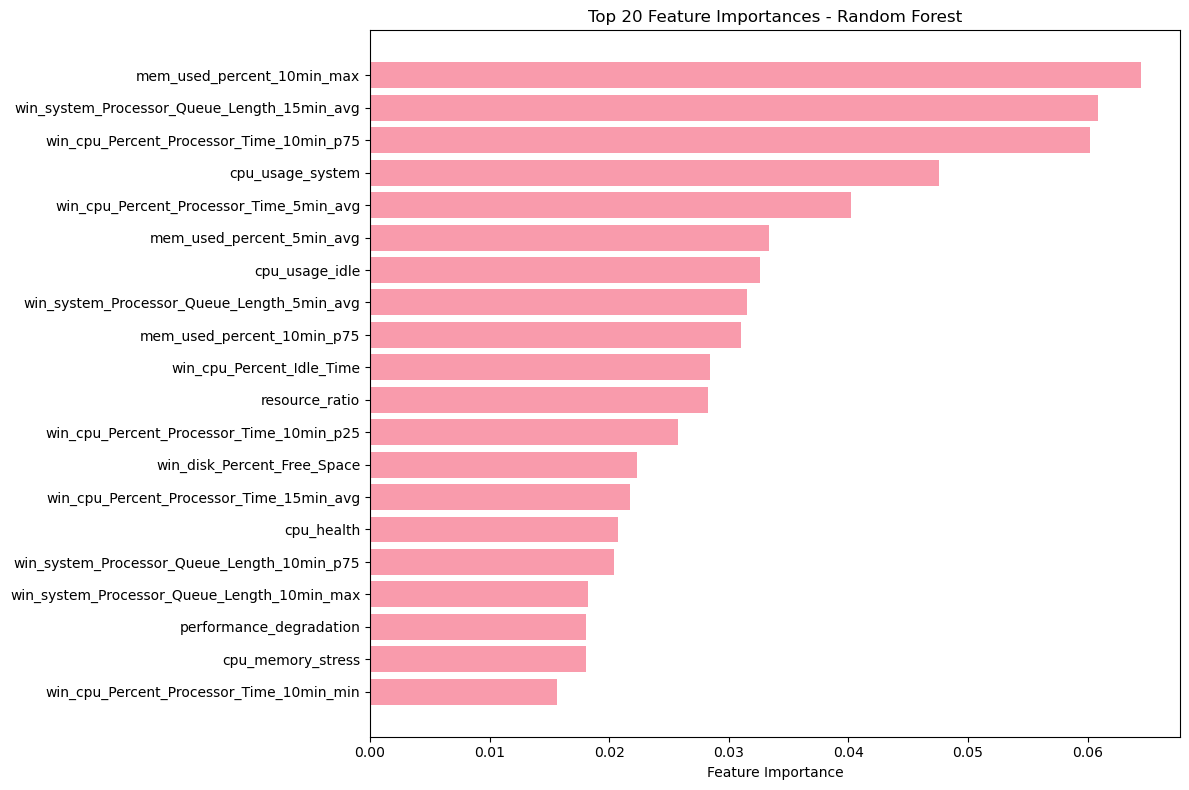


8. PREDICTION THRESHOLD OPTIMIZATION:
Optimal probability threshold: 0.802
At optimal threshold:
  Precision: 0.590
  Recall: 0.750
  F1-Score: 0.661

Confusion Matrix with Optimal Threshold:
[[2085   25]
 [  12   36]]

9. CROSS-VALIDATION:
5-Fold Cross-Validation AUC Scores:
  Fold 1: 0.982
  Fold 2: 0.973
  Fold 3: 0.914
  Fold 4: 0.843
  Fold 5: 0.930

Cross-Validation Summary:
  Mean AUC: 0.928
  Std AUC: 0.050
  95% CI: [0.830, 1.026]

MODEL DEVELOPMENT SUMMARY:
✅ Tested 4 algorithms with 3 sampling strategies
✅ Best model: Random Forest (Undersampling) with AUC = 0.946
✅ Optimized prediction threshold: 0.802
✅ Ready for final testing and deployment


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("=== STEP 5: MODEL DEVELOPMENT AND TRAINING ===")

# ------------------------------------------------------------------
# Helper: Clean NaNs/Infs/Extremes
# ------------------------------------------------------------------
def clean_data(X):
    """Replace inf with NaN, then fill NaN with column median."""
    X_cleaned = np.where(np.isinf(X), np.nan, X)
    for col in range(X_cleaned.shape[1]):
        col_data = X_cleaned[:, col]
        median_val = np.nanmedian(col_data)
        mask = np.isnan(col_data)
        X_cleaned[mask, col] = median_val
    return X_cleaned

# ------------------------------------------------------------------
# 1. DATA PREPARATION
# ------------------------------------------------------------------
exclude_cols = [
    'timestamp', 'time_diff', 'time_diff_seconds', 'large_gap', 
    'cpu_spike', 'memory_spike', 'queue_spike', 'temp_spike',
    'failure_next', 'failure_event', 'multiple_anomalies'
]

feature_cols = [col for col in df_features.columns 
               if col not in exclude_cols and not col.endswith('_is_anomaly') 
               and col != 'failure_in_10min']

X = df_features[feature_cols]
y = df_features['failure_in_10min']

print("1. DATA PREPARATION:")
print("=" * 50)
print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")
print(f"Class distribution:")
print(f"  Normal (0): {(y == 0).sum()} ({(y == 0).mean()*100:.1f}%)")
print(f"  Failure (1): {(y == 1).sum()} ({(y == 1).mean()*100:.1f}%)")

# Chronological split
n_samples = len(X)
train_end = int(0.6 * n_samples)  # 60% for training
val_end = int(0.8 * n_samples)    # 20% for validation

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]
X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]
X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

print(f"\nData splits (chronological):")
print(f"  Train: {X_train.shape[0]} samples")
print(f"  Validation: {X_val.shape[0]} samples") 
print(f"  Test: {X_test.shape[0]} samples")

print(f"\nClass distribution in splits:")
for name, y_split in [('Train', y_train), ('Validation', y_val), ('Test', y_test)]:
    pos_rate = (y_split == 1).mean() * 100
    print(f"  {name}: {pos_rate:.1f}% failures")

# ------------------------------------------------------------------
# 2. FEATURE CLEANING + SCALING
# ------------------------------------------------------------------
print("\n2. FEATURE CLEANING & SCALING:")
print("=" * 50)

X_train = pd.DataFrame(clean_data(X_train.values), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(clean_data(X_val.values), columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(clean_data(X_test.values), columns=X_test.columns, index=X_test.index)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Cleaned and scaled features")

# ------------------------------------------------------------------
# 3. HANDLING CLASS IMBALANCE
# ------------------------------------------------------------------
print("\n3. HANDLING CLASS IMBALANCE:")
print("=" * 50)

sampling_strategies = {}
sampling_strategies['Original'] = (X_train_scaled, y_train)

# SMOTE
try:
    smote = SMOTE(random_state=42, k_neighbors=min(5, (y_train == 1).sum() - 1))
    X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)
    sampling_strategies['SMOTE'] = (X_smote, y_smote)
    print(f"✅ SMOTE: {X_smote.shape[0]} samples")
except:
    print("❌ SMOTE failed (insufficient minority samples)")

# Random undersampling
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train_scaled, y_train)
sampling_strategies['Undersampling'] = (X_under, y_under)
print(f"✅ Undersampling: {X_under.shape[0]} samples")

# ------------------------------------------------------------------
# 4. MODEL TRAINING
# ------------------------------------------------------------------
print("\n4. MODEL TRAINING:")
print("=" * 50)

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        max_depth=10, 
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    ),
    'SVM': SVC(
        kernel='rbf',
        probability=True,
        random_state=42,
        class_weight='balanced'
    )
}

results = {}
for sampling_name, (X_samp, y_samp) in sampling_strategies.items():
    print(f"\n--- {sampling_name} Strategy ---")
    results[sampling_name] = {}
    
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        try:
            model.fit(X_samp, y_samp)
            y_pred = model.predict(X_val_scaled)
            y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
            auc = roc_auc_score(y_val, y_pred_proba)
            results[sampling_name][model_name] = {
                'model': model,
                'auc': auc,
                'predictions': y_pred,
                'probabilities': y_pred_proba
            }
            print(f"  AUC: {auc:.3f}")
        except Exception as e:
            print(f"  ❌ Failed: {e}")

# ------------------------------------------------------------------
# 5. MODEL COMPARISON
# ------------------------------------------------------------------
print("\n5. MODEL COMPARISON:")
print("=" * 50)

best_auc = 0
best_model = None
best_sampling = None
best_model_name = None
comparison_results = []

for sampling_name in results:
    for model_name in results[sampling_name]:
        auc = results[sampling_name][model_name]['auc']
        comparison_results.append({
            'Sampling': sampling_name,
            'Model': model_name,
            'AUC': auc
        })
        if auc > best_auc:
            best_auc = auc
            best_model = results[sampling_name][model_name]['model']
            best_sampling = sampling_name
            best_model_name = model_name

comparison_df = pd.DataFrame(comparison_results).pivot(index='Model', columns='Sampling', values='AUC')
print("AUC Comparison Matrix:")
print(comparison_df.round(3))

print(f"\n🏆 Best Model: {best_model_name} with {best_sampling}")
print(f"   Best AUC: {best_auc:.3f}")

# ------------------------------------------------------------------
# 6. DETAILED EVALUATION
# ------------------------------------------------------------------
print("\n6. DETAILED EVALUATION OF BEST MODEL:")
print("=" * 50)

if best_model is not None:
    best_predictions = results[best_sampling][best_model_name]['predictions']
    best_probabilities = results[best_sampling][best_model_name]['probabilities']
    
    print("Classification Report (Validation Set):")
    print(classification_report(y_val, best_predictions))
    
    print("\nConfusion Matrix (Validation Set):")
    cm = confusion_matrix(y_val, best_predictions)
    print(cm)
    
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    if tp + fn > 0:
        recall = tp / (tp + fn)
        print(f"\nKey Metrics:")
        print(f"  True Positives: {tp}")
        print(f"  False Negatives: {fn}")
        print(f"  False Positives: {fp}")
        print(f"  True Negatives: {tn}")
        print(f"  Recall: {recall:.3f}")
        if tp + fp > 0:
            precision = tp / (tp + fp)
            print(f"  Precision: {precision:.3f}")

# ------------------------------------------------------------------
# 7. FEATURE IMPORTANCE
# ------------------------------------------------------------------
print("\n7. FEATURE IMPORTANCE ANALYSIS:")
print("=" * 50)

if best_model is not None and hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 15 Features:")
    for i, row in importance_df.head(15).iterrows():
        print(f"{row.name+1:2d}. {row['feature']:<45} {row['importance']:.4f}")
    
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(20)
    plt.barh(range(len(top_features)), top_features['importance'], alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------
# 8. THRESHOLD OPTIMIZATION
# ------------------------------------------------------------------
print("\n8. PREDICTION THRESHOLD OPTIMIZATION:")
print("=" * 50)

if best_model is not None:
    precision, recall, thresholds = precision_recall_curve(y_val, best_probabilities)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    
    print(f"Optimal probability threshold: {optimal_threshold:.3f}")
    print(f"At optimal threshold:")
    print(f"  Precision: {precision[optimal_idx]:.3f}")
    print(f"  Recall: {recall[optimal_idx]:.3f}")
    print(f"  F1-Score: {f1_scores[optimal_idx]:.3f}")
    
    optimal_predictions = (best_probabilities >= optimal_threshold).astype(int)
    cm_opt = confusion_matrix(y_val, optimal_predictions)
    print("\nConfusion Matrix with Optimal Threshold:")
    print(cm_opt)

# ------------------------------------------------------------------
# 9. CROSS-VALIDATION
# ------------------------------------------------------------------
print("\n9. CROSS-VALIDATION:")
print("=" * 50)

if best_model is not None and best_sampling in sampling_strategies:
    X_best, y_best = sampling_strategies[best_sampling]
    X_best_cleaned = clean_data(X_best)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(best_model, X_best_cleaned, y_best, cv=skf, scoring='roc_auc')
    
    print("5-Fold Cross-Validation AUC Scores:")
    for i, score in enumerate(cv_scores, 1):
        print(f"  Fold {i}: {score:.3f}")
    
    print(f"\nCross-Validation Summary:")
    print(f"  Mean AUC: {cv_scores.mean():.3f}")
    print(f"  Std AUC: {cv_scores.std():.3f}")
    print(f"  95% CI: [{cv_scores.mean() - 1.96*cv_scores.std():.3f}, {cv_scores.mean() + 1.96*cv_scores.std():.3f}]")

# ------------------------------------------------------------------
# SUMMARY
# ------------------------------------------------------------------
print("\n" + "="*80)
print("MODEL DEVELOPMENT SUMMARY:")
print(f"✅ Tested {len(models)} algorithms with {len(sampling_strategies)} sampling strategies")
print(f"✅ Best model: {best_model_name} ({best_sampling}) with AUC = {best_auc:.3f}")
print(f"✅ Optimized prediction threshold: {optimal_threshold:.3f}")
print("✅ Ready for final testing and deployment")
print("="*80)
